In [34]:
%matplotlib inline  
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import imp
import numpy as np
import os
import matplotlib.pyplot as plt

import keras
import keras.backend
import keras.models

import innvestigate
import innvestigate.applications.imagenet
import innvestigate.utils as iutils

import imp
#base_dir = os.path.dirname(__file__)
utils = imp.load_source("utils", "../utils.py")
imgnetutils = imp.load_source("utils_imagenet", "../utils_imagenet.py")
main = imp.load_source("main", "../main.py")
METHODS = main.METHODS
create_vgg16_model_and_analyzer = main.create_vgg16_model_and_analyzer
analyze = main.analyze
visualize = main.visualize


In [2]:
# To use this script please download the example images using the following script:
# innvestigate/examples/images/wget_imagenet_2011_samples.sh
#method_names=['input', 'pattern.net',]
#method_names = ['input', 'gradient', 'pattern.net*gradient']
method_names = ['input', 'gradient', 'deep_taylor.bounded', 'pattern.attribution', 'pattern.net', 'input_t_gradient']# 'input*gradient', 'pattern.net*gradient', ]
#method_names = ['input', 'gradient', 'pattern.net',]# 'input_t_gradient']
model, net, analyzers = create_vgg16_model_and_analyzer(methods_metadata=METHODS, analyzer_names=method_names)

images, label_to_class_name = utils.get_imagenet_data(net["image_shape"][0])

if not len(images):
    raise Exception("Please download the example images using: "
                    "'innvestigate/examples/images/wget_imagenet_2011_samples.sh'")


Instructions for updating:
Colocations handled automatically by placer.


In [3]:
analysis, text = analyze(data=images[:1], analyzers=analyzers, net=net, model=model, label_to_class_name=label_to_class_name)

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


In [31]:
analysis_dict = {method_name: np.expand_dims(analysis[:,idx], axis=1) for idx, method_name in enumerate(method_names)}
#gradient_projected = scale_max_batch(analysis_dict['gradient'], input_is_positive_only=True)
analysis_dict['gradient*input'] = analysis_dict['gradient'] * analysis_dict['input']
#gradient_t_input = analysis_dict['input']
#patternnet_clip = np.clip(analysis_dict['pattern.net'], a_min=0, a_max=None)
#analysis_dict['abs(pattern.net)'] = np.abs(analysis_dict['pattern.net'])
analysis_dict['gradient*pattern.net'] = analysis_dict['gradient'] * analysis_dict['pattern.net']
analysis_dict['abs(gradient)*abs(pattern.net)'] = np.abs(analysis_dict['gradient']) * np.abs(analysis_dict['pattern.net'])
#method_names = method_names + ['abs(pattern.net)']
#gradient_t_patternnet = analysis_dict['gradient'] * analysis_dict['pattern.net']

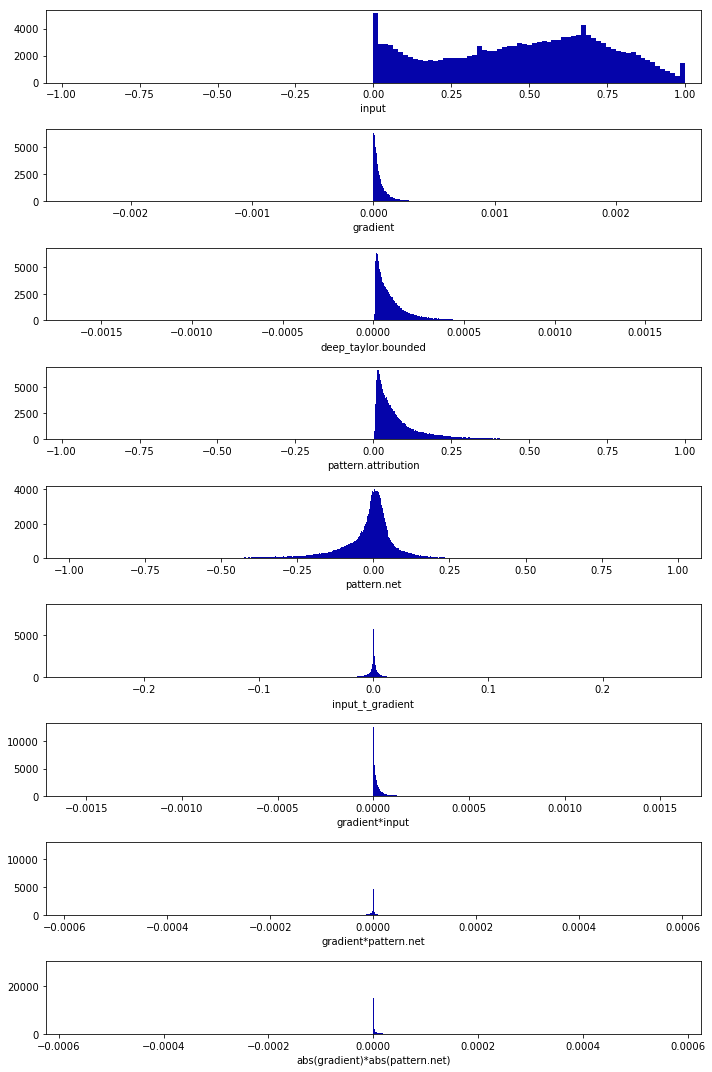

In [32]:
# show value distribution for all analysis
fig, axs = plt.subplots(len(analysis_dict), 1, tight_layout=True, figsize=(10, 15)) #sharey=True, 
for i, method_name in enumerate(analysis_dict):
    #print('{:15} [{:.5f}, {:.5f}]'.format(method_name, analysis[:, i].min(), analysis[:, i].max()))
    data = analysis_dict[method_name].reshape((-1))
    #print(data.shape)
    axs[i].hist(data, bins='auto', color='#0504aa')#, alpha=0.7)   # slow
    #axs[i].hist(data, bins=300, color='#0504aa')#, alpha=0.7)
    
    # center to x=0
    axs[i].set_xlabel(method_name)
    left, right = axs[i].get_xlim()
    max_xlim = max(abs(left), abs(right))
    axs[i].set_xlim(-max_xlim, max_xlim)
    #print(left, right, '->', -max_xlim, max_xlim)
    
    #axs[i].yaxis.set_label_position("right")


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

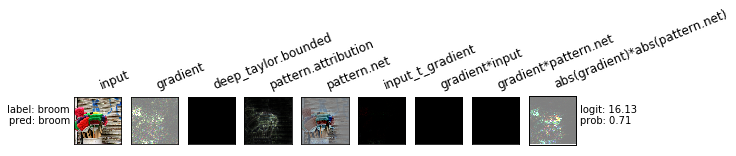

In [35]:
visualization_transformations = {
        'default': imgnetutils.bk_proj,
        'input': None,
        'gradient': imgnetutils.bk_proj,
        'deep_taylor.bounded': None,
        'pattern.attribution': None,
        'pattern.net': imgnetutils.bk_proj,
        'input_t_gradient': None,
        'gradient*input': None,
        'gradient*pattern.net': None,
        'abs(pattern.net)': imgnetutils.bk_proj
}
visualize(np.concatenate([analysis_dict[mn] for mn in analysis_dict], axis=1),
          text, list(analysis_dict),
          visualization_transformations=visualization_transformations,
          #figsize=(10, 2)
         )